<a href="https://colab.research.google.com/github/hsiehbocheng/credit-issuance-analysis/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
！pip install shap
import pandas as pd
import numpy as np
import shap
from typing import Dict, List, Tuple, Union
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from xgboost import XGBClassifier

SyntaxError: ignored

**吳育瑋老師三堂精彩的課程，向我們介紹特徵選取的方式、決策樹與隨機森林的基礎、可解釋AI 套件（shap, lime ... etc.）這邊我使用一筆信用卡核發資料，該資料是一筆結構化資料，y 是二元類別變數，可以使用決策樹做預測或是XGBoost，接著我使用shap 套件去做重要特徵的分析**<br><br>
- 資料來源：書本《Econometric Analysis》
- [Kaggle 資料連結](https://www.kaggle.com/datasets/dansbecker/aer-credit-card-data)
- [SHAP documents 參考](https://github.com/slundberg/shap)

In [ ]:
credit = pd.read_csv('data/AER_credit_card_data.csv')

### **data description**

- **card**:<br>
    Dummy variable, 1 if application for credit card accepted, 0 if not<br>
    代表是否核發卡片
- **reports**:<br>
      Number of major derogatory reports<br>信用卡違規紀錄次數<br>
- **age**:<br> Age n years plus twelfths of a year<br>年齡<br>
- **income**: <br>Yearly income (divided by 10,000)<br>年收入<br>
- **share**: <br>Ratio of monthly credit card expenditure to yearly income<br>信用卡消費金額占年收之比率<br>
- **expenditure**:<br> Average monthly credit card expenditure<br>信用卡消費金額<br>
- **owner**: <br>1 if owns their home, 0 if rent<br>申請人是否擁有房地產<br>
- **selfemp**: <br>1 if self employed, 0 if not.<br>申請人是否自行創業<br>
- **dependents**: <br>1 + number of dependents<br>申請人家庭人數<br>
- **months**:<br> Months living at current address<br>於現居住地之居住時長<br>
- **majorcards**: <br>Number of major credit cards held<br>現持有信用卡數量<br>
- **active**:<br> Number of active credit accounts<br>活動中的信用賬戶數量<br>

In [ ]:
categorical_col = [col for col in list(credit.columns) if type(credit[col][0]) == str]

In [ ]:
categorical_col = [col for col in list(credit.columns) if type(credit[col][0]) == str]
for col in categorical_col:
    credit[col] = credit[col].map(lambda x: 1 if x == 'yes' else 0)
# credit['card'] = credit['card'].astype(str)

Text(0.5, 0, 'Income')

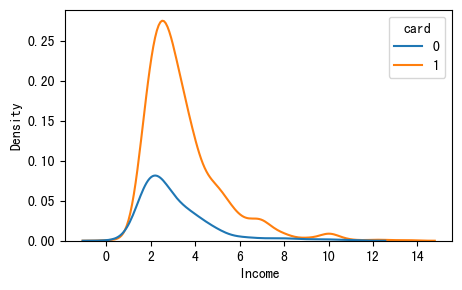

In [ ]:
plt.figure(figsize=(5, 3))
sns.kdeplot(data=credit, x='income', hue='card')
# legend = {1: 'yes', 0: 'no'}
plt.xlabel('Income')

Text(0.5, 0, '活動信用帳戶數')

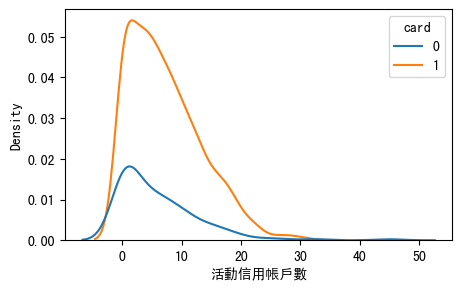

In [ ]:
plt.figure(figsize=(5, 3))
sns.kdeplot(data=credit, x='active', hue='card')
# legend = {1: 'yes', 0: 'no'}
plt.xlabel('活動信用帳戶數')

Text(0.5, 0, '持有信用卡數')

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


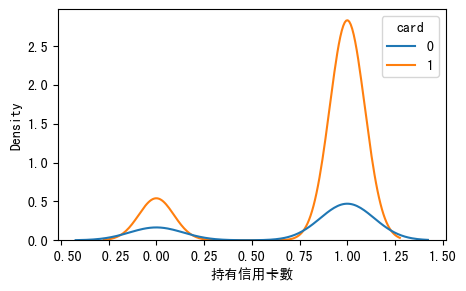

In [ ]:
plt.figure(figsize=(5, 3))
sns.kdeplot(data=credit, x='majorcards', hue='card')
# legend = {1: 'yes', 0: 'no'}
plt.xlabel('持有信用卡數')

Text(0.5, 0, '是否核發卡片')

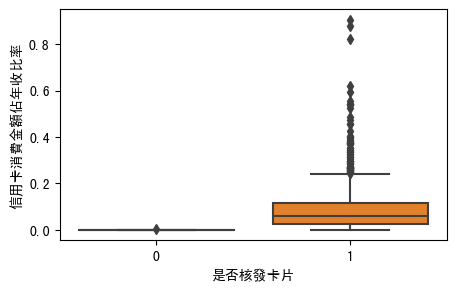

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=credit, y='share', x='card')
# legend = {1: 'yes', 0: 'no'}
plt.ylabel('信用卡消費金額佔年收比率')
plt.xlabel('是否核發卡片')

Text(0.5, 0, '持有信用卡數')

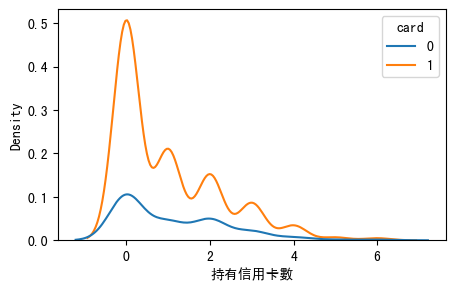

In [ ]:
plt.figure(figsize=(5, 3))
sns.kdeplot(data=credit, x='dependents', hue='card')
# legend = {1: 'yes', 0: 'no'}
plt.xlabel('持有信用卡數')

In [ ]:
modelData = credit
train, test = train_test_split(modelData, test_size=0.3, random_state=123)
X_train, y_train = np.array(train.drop(columns='card')), np.array(train.card).reshape(-1, 1)
X_test, y_test = np.array(test.drop(columns='card')), np.array(test.card).reshape(-1, 1)

**建立Decision Tree Model，切分變數的criterion 使用gini 指標。**

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, y_train)

DecisionTreeClassifier()

**分類報表與混淆矩陣**

In [ ]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93        90
           1       0.98      0.98      0.98       306

    accuracy                           0.97       396
   macro avg       0.95      0.96      0.95       396
weighted avg       0.97      0.97      0.97       396

[[ 84   6]
 [  7 299]]


**視覺化決策樹，輸出成pdf 檔案**

In [ ]:
from six import StringIO
import pydoc
import pydotplus

dot_date = StringIO()
features = list(train.drop(columns='card').columns)
tree.export_graphviz(clf,
                    out_file=dot_date,
                    feature_names=features,
                    class_names=clf.classes_,
                    filled=True,
                    rounded=True,
                    impurity=False)
graph = pydotplus.graph_from_dot_data(dot_date.getvalue())
graph.write_pdf("decisionTree.pdf")

True

<img src="data/decisionTree.png" height='800' alt='決策樹視覺化'>

**從上面可以看出，Expenditure(信用卡消費金額) 會是樹的root，可以當成是較為重要的特徵，代表在這筆資料中，若有使用信用卡消費金額的習慣，會是核發信用卡與否的重要特徵，接下來則是看report (信用卡違規紀錄次數) 這項特徵，接著像是Age (年齡）、Months （於現居住地之居住時常）...... 等等特徵**

In [ ]:
xgb = XGBClassifier()
model = xgb.fit(X_train, y_train)

In [ ]:
pred = xgb.predict(X_test)
print(classification_report(y_test, pred))
pd.DataFrame(confusion_matrix(y_test, pred), 
            columns=['Predict Negative', 
                    'Predcit Positive'],
            index=['True Negative', 
                    'True Positive'])

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        90
           1       0.99      0.98      0.99       306

    accuracy                           0.98       396
   macro avg       0.96      0.98      0.97       396
weighted avg       0.98      0.98      0.98       396



,Predict Negative,Predcit Positive
True Negative,88,2
True Positive,6,300


**發現使用XGBoost，accuracy 或是Precision, Recall, f1-score 都比決策樹再好一點，雖然在這資料中，決策樹表現已經很不錯了，但普遍情況決策樹的確表現不會到這麼高，而XGBoost 可以表現的差距就出來，但是缺點是XGBoost 無法像決策樹有那麼明確的流程，那就可以使用到XAI 套件，這裡使用shap**

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(train.drop(columns='card'))

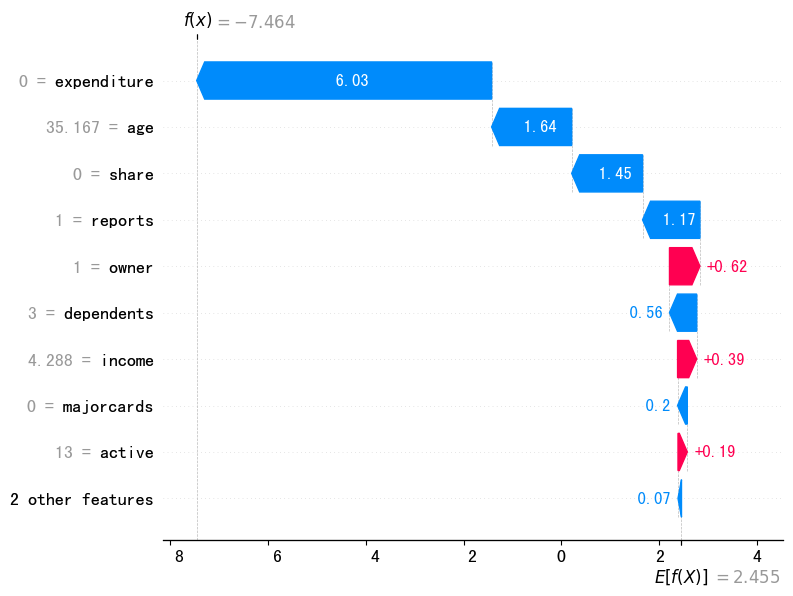

In [ ]:
shap.plots.waterfall(shap_values[0])

**上圖呈現在其中一筆資料中，該資料之預測結果的原因，藍色值的特徵，在值越低時越會將預測推低（預測至Negative)而紅色則是越高時會將預測推向Positive**

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


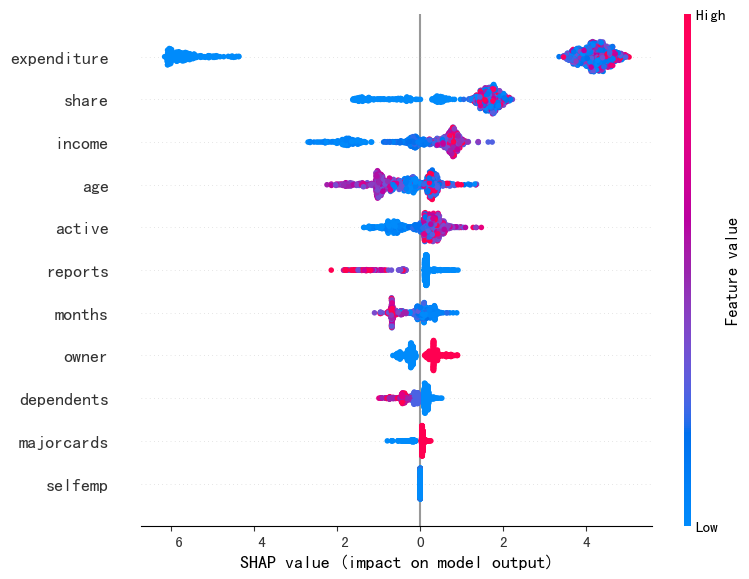

In [ ]:
shap.summary_plot(shap_values, train.drop(columns='card'))

**而上圖則是整體資料的summary 對每個樣本繪製特徵的SHAP Value，可以看到overall 的呈現，而每個點代表一項觀測值，而該點之嵐紅色則像是上面所說，紅色代表該值越高時會將預測結果推高**

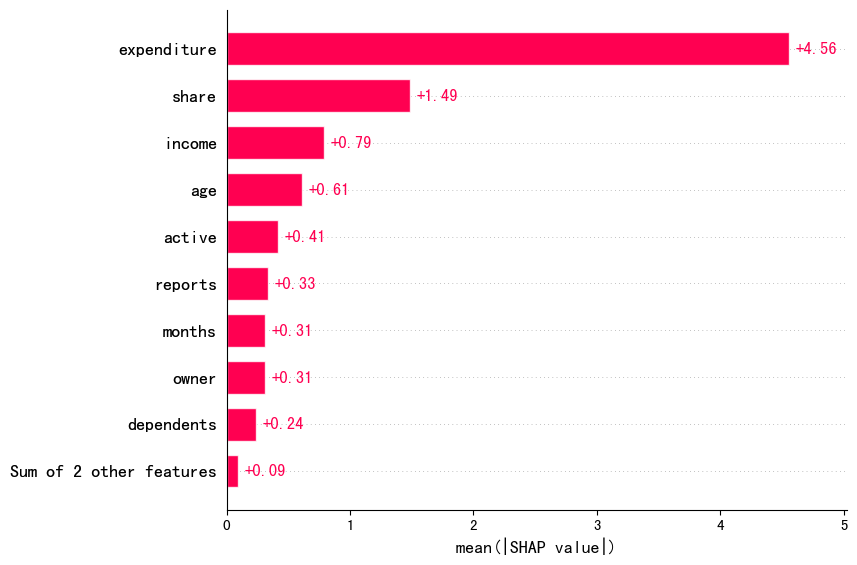

In [ ]:
shap.plots.bar(shap_values)

**上圖則時簡單對SHAP Value 取平均值，可當成特徵之重要性排序。<br><br>統整上面所看到，其實XGBoost + SHAPE 對特徵的解釋跟決策樹是大同小異，最重要的變數都是Expenditure（信用卡消費之金額），但後續重要變數的排序則略有不同，但是可以從這筆資料看出不論是XGBoost 或是 Decision Tree，習慣之信用卡消費金額對於是否核發卡片是最重要之特徵。**

In [ ]:
shap.initjs()

In [ ]:
shap.plots.force(shap_values)